In [1]:
import wandb
import sys
import warnings
from pathlib import Path
import optuna
import pandas as pd

import os
import sys

from otc.features.build_features import (
    features_categorical,
    features_classical,
    features_classical_size,
    features_ml,
)

from __future__ import annotations

from typing import Any, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from tqdm.auto import tqdm

/pfs/data5/home/kit/stud/uloak/thesis/thesis/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EXCHANGE = "ise"
STRATEGY = "supervised"

In [3]:
dataset = f"fbv/thesis/{EXCHANGE}_{STRATEGY}_none:latest"

os.environ["GCLOUD_PROJECT"] = "flowing-mantis-239216"

run = wandb.init(project="thesis", entity="fbv")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


In [4]:
# download labelled
artifact_labelled = run.use_artifact(dataset)
artifact_dir_labelled = artifact_labelled.download()

# download unlabelled
unlabelled_dataset = dataset.replace("supervised", "unsupervised")
artifact_unlabelled = run.use_artifact(unlabelled_dataset)
artifact_dir_unlabelled = artifact_unlabelled.download()

x_train_unlabelled = pd.read_parquet(
            Path(artifact_dir_unlabelled, "train_set.parquet"), columns=["buy_sell", *features_classical_size]
        )

# labelled data
x_train_labelled = pd.read_parquet(
            Path(artifact_dir_labelled, "train_set.parquet"), columns=["buy_sell", *features_classical_size]
)

x_train_unlabelled["src"] = "unlabelled"
x_train_labelled["src"] = "labelled"


# load unscaled data
# artifact_labelled = run.use_artifact(dataset)
# artifact_dir_labelled = artifact_labelled.download()
# x_train = pd.concat([x_train_labelled, x_train_unlabelled])
# y_train = pd.concat([y_train_labelled, y_train_unlabelled])

wandb: Downloading large artifact ise_supervised_none:latest, 4203.92MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.0
wandb: Downloading large artifact ise_unsupervised_none:latest, 1076.86MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.0


In [5]:
x_train_unlabelled.head().T

index_labelled,2.724860e+07,2.724860e+07,2.724860e+07,2.724860e+07,2.724860e+07
buy_sell,0,0,0,0,0
TRADE_PRICE,0.45,0.47,1.86,2.02,3.03
bid_ex,NaN,NaN,NaN,1.82,2.99
ask_ex,NaN,NaN,NaN,2.02,3.1
BEST_ASK,0.0,0.62,0.0,2.02,3.1
BEST_BID,0.0,0.55,0.0,1.82,2.99
price_ex_lag,NaN,0.76,1.83,1.9,3.27
price_ex_lead,0.67,0.56,1.8,1.88,3.26
price_all_lag,NaN,0.57,1.87,1.89,3.2
price_all_lead,0.4,0.55,1.76,1.86,3.07


In [6]:
x_train_unlabelled.index.min()

27248577.4

In [7]:
x_train_unlabelled.index.max()

29510319.0

In [8]:
# slice to same time range as unlabelled trades
x_train_labelled = x_train_labelled.iloc[27248577 : 29510319]

In [9]:
x_train_labelled

,buy_sell,TRADE_PRICE,bid_ex,ask_ex,BEST_ASK,BEST_BID,price_ex_lag,price_ex_lead,price_all_lag,price_all_lead,...,prox_ex,prox_best,bid_ask_size_ratio_ex,rel_bid_size_ex,rel_ask_size_ex,TRADE_SIZE,bid_size_ex,ask_size_ex,depth_ex,src
index,,,,,,,,,,,,,,,,,,,,,
27248600,-1,1.95,NaN,NaN,0.00,0.00,2.10,1.90,3.52,1.85,...,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,labelled
27248599,1,1.65,1.40,1.65,1.65,1.40,1.70,1.60,3.22,1.45,...,1.000000,1.000000,1.000000,0.047619,0.047619,1,21.0,21.0,0.0,labelled
27248601,1,1.65,1.40,1.65,1.65,1.40,1.70,1.60,3.22,1.45,...,1.000000,1.000000,1.000000,0.428571,0.428571,9,21.0,21.0,0.0,labelled
27248597,1,3.10,2.70,3.10,3.10,2.70,2.96,3.00,3.00,3.00,...,0.999999,0.999999,0.916667,0.045455,0.041667,1,22.0,24.0,-2.0,labelled
27248596,1,3.10,2.70,3.10,3.10,2.70,2.96,3.00,3.00,3.00,...,0.999999,0.999999,0.916667,0.090909,0.083333,2,22.0,24.0,-2.0,labelled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29510314,-1,0.50,0.49,0.53,0.53,0.49,0.53,0.47,0.54,0.47,...,-0.500000,-0.500000,1.701351,0.002648,0.004505,10,3777.0,2220.0,1557.0,labelled
29510315,-1,0.15,0.15,0.19,0.17,0.15,0.16,0.16,0.16,0.16,...,-1.000000,-0.999999,1.653846,1.000000,1.653846,43,43.0,26.0,17.0,labelled
29510316,1,0.60,0.56,0.60,0.60,0.56,0.72,0.47,0.72,0.42,...,0.999999,0.999999,0.500000,0.100000,0.050000,1,10.0,20.0,-10.0,labelled


In [10]:
data = pd.concat([x_train_labelled, x_train_unlabelled]).sample(frac=0.10)

In [11]:
def plot_kde_src(var_name: str, clip: List[float] | None = None):
    """
    Plot kde plots for labelled and unlabelled with regard to the feature 'var_name'.

    Args:
        var_name (str): name of feature
        clip (List[float] | None, optional): clipping range. Defaults to None.
    """

    median_unlabelled = data[data["src"] == "unlabelled"][var_name].median()
    median_labelled = data[data["src"] == "labelled"][var_name].median()

    _, ax = plt.subplots()
    for i in ["unlabelled", "labelled"]:
        sns.kdeplot(
            data=data[data["src"] == i][var_name],
            clip=clip,
            label=str(i),
            cumulative=True,
            common_grid=True,
            # common_norm=True,
        )
    ax.title.set_text(f"Distribution of '{var_name}'")
    ax.legend()
    sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
    plt.show()

    print(f"Median value of unlabelled = {median_unlabelled: 0.4f}")
    print(f"Median value of labelled = {median_labelled: 0.4f}")

In [12]:
data.columns

Index(['buy_sell', 'TRADE_PRICE', 'bid_ex', 'ask_ex', 'BEST_ASK', 'BEST_BID',
       'price_ex_lag', 'price_ex_lead', 'price_all_lag', 'price_all_lead',
       'chg_ex_lead', 'chg_ex_lag', 'chg_all_lead', 'chg_all_lag', 'prox_ex',
       'prox_best', 'bid_ask_size_ratio_ex', 'rel_bid_size_ex',
       'rel_ask_size_ex', 'TRADE_SIZE', 'bid_size_ex', 'ask_size_ex',
       'depth_ex', 'src'],
      dtype='object')

  0%|          | 0/22 [00:00<?, ?it/s]

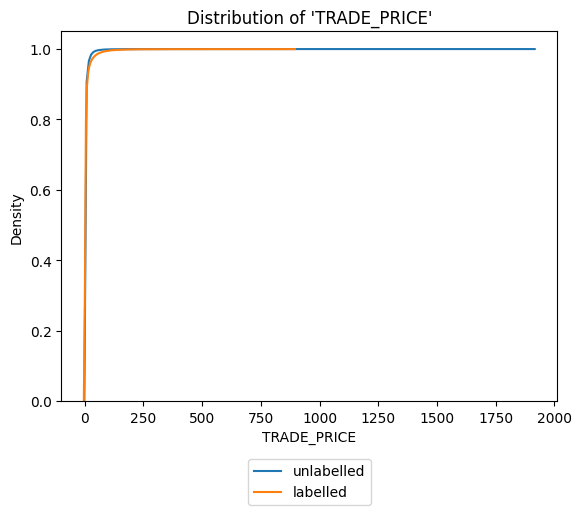

  5%|▍         | 1/22 [00:15<05:27, 15.60s/it]

Median value of unlabelled =  1.2500
Median value of labelled =  1.3100


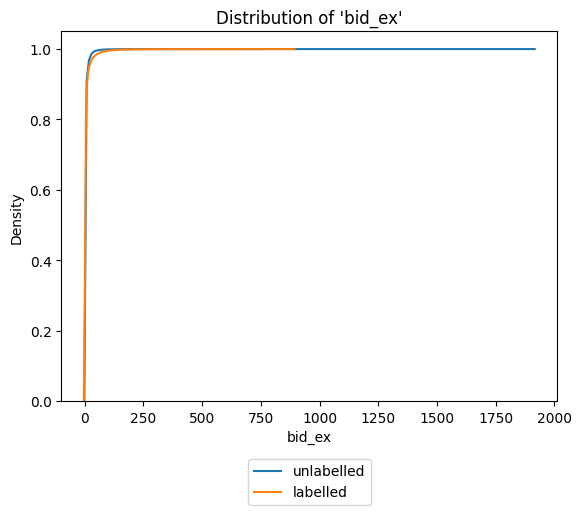

  9%|▉         | 2/22 [00:30<04:59, 14.96s/it]

Median value of unlabelled =  1.2000
Median value of labelled =  1.2500


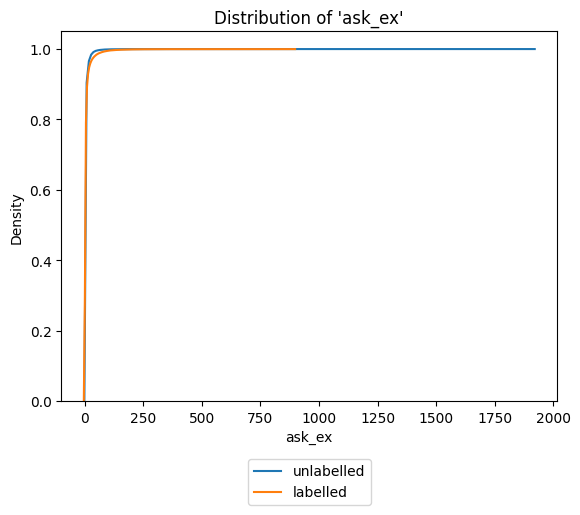

 14%|█▎        | 3/22 [00:44<04:40, 14.76s/it]

Median value of unlabelled =  1.2900
Median value of labelled =  1.3800


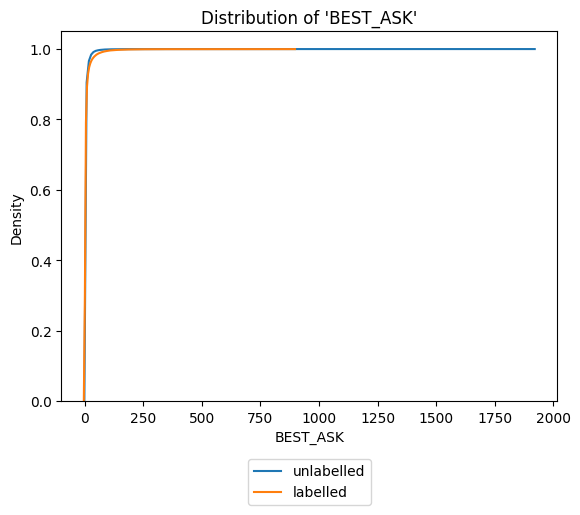

 18%|█▊        | 4/22 [00:59<04:23, 14.64s/it]

Median value of unlabelled =  1.2700
Median value of labelled =  1.3500


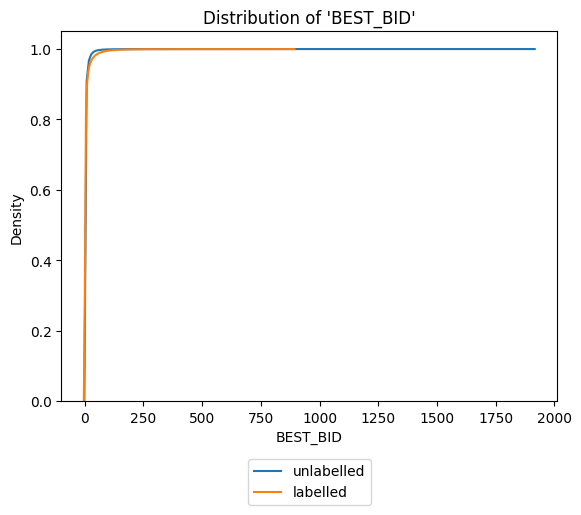

 23%|██▎       | 5/22 [01:13<04:07, 14.56s/it]

Median value of unlabelled =  1.2200
Median value of labelled =  1.2600


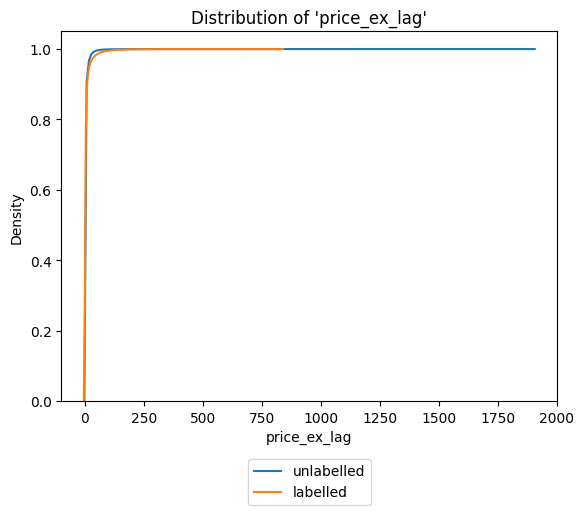

 27%|██▋       | 6/22 [01:27<03:51, 14.44s/it]

Median value of unlabelled =  1.2500
Median value of labelled =  1.4000


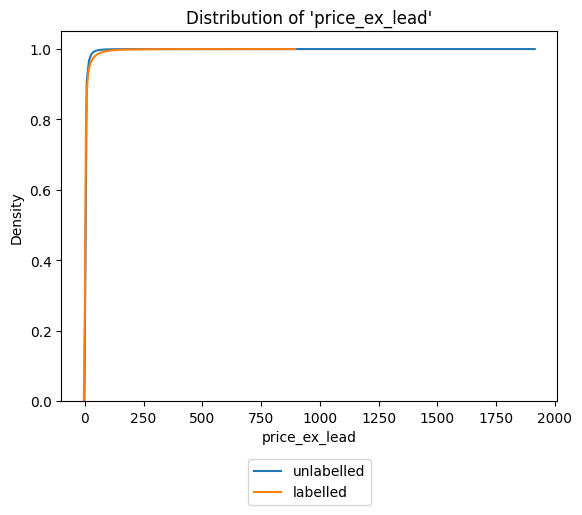

 32%|███▏      | 7/22 [01:41<03:34, 14.33s/it]

Median value of unlabelled =  1.2500
Median value of labelled =  1.3600


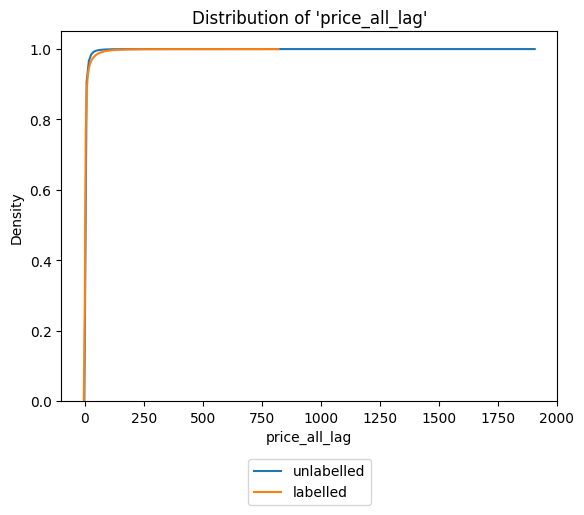

 36%|███▋      | 8/22 [01:56<03:21, 14.36s/it]

Median value of unlabelled =  1.2500
Median value of labelled =  1.3500


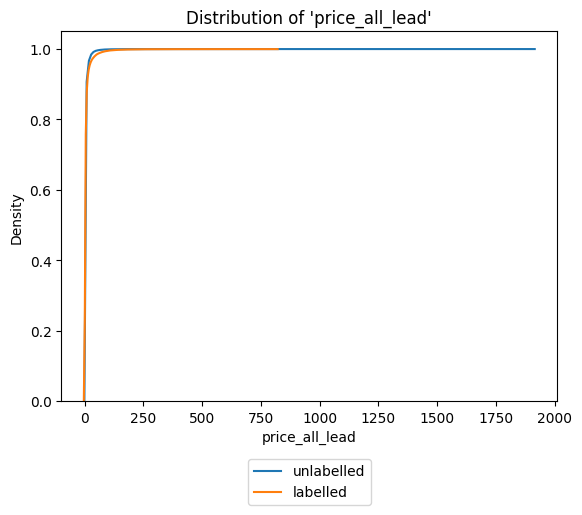

 41%|████      | 9/22 [02:10<03:06, 14.37s/it]

Median value of unlabelled =  1.2500
Median value of labelled =  1.3500


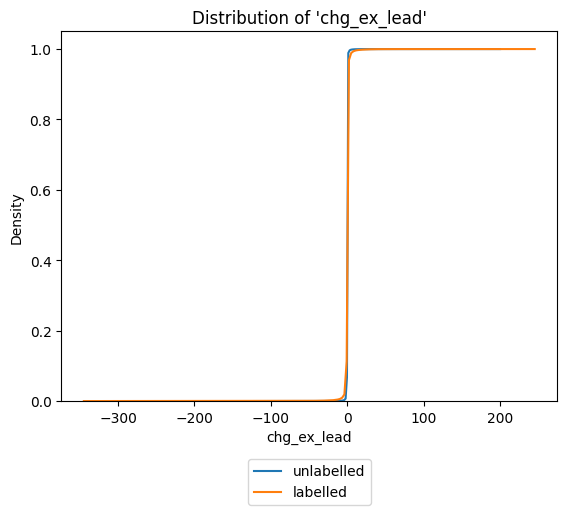

 45%|████▌     | 10/22 [02:19<02:33, 12.76s/it]

Median value of unlabelled =  0.0100
Median value of labelled =  0.0100


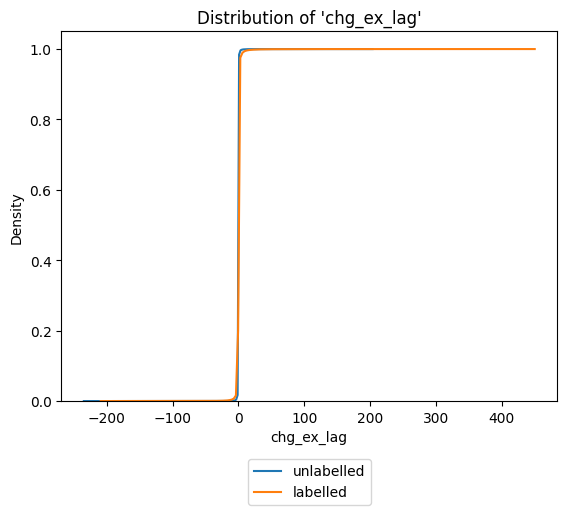

 50%|█████     | 11/22 [02:28<02:05, 11.39s/it]

Median value of unlabelled = -0.0100
Median value of labelled = -0.0100


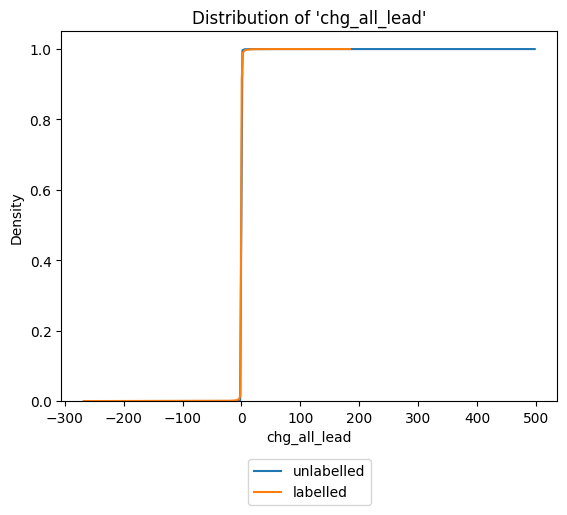

 55%|█████▍    | 12/22 [02:36<01:44, 10.47s/it]

Median value of unlabelled =  0.0100
Median value of labelled =  0.0100


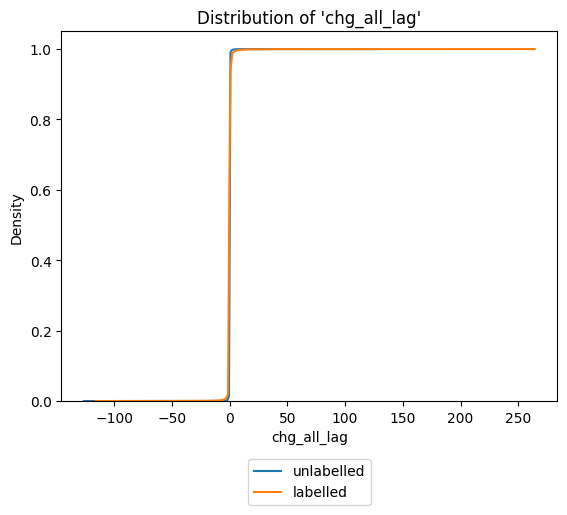

 59%|█████▉    | 13/22 [02:44<01:28,  9.84s/it]

Median value of unlabelled = -0.0100
Median value of labelled = -0.0100


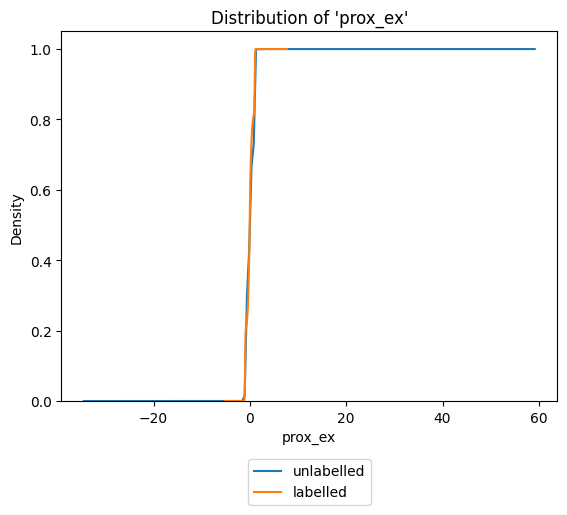

 64%|██████▎   | 14/22 [02:53<01:16,  9.56s/it]

Median value of unlabelled =  0.0000
Median value of labelled =  0.0000


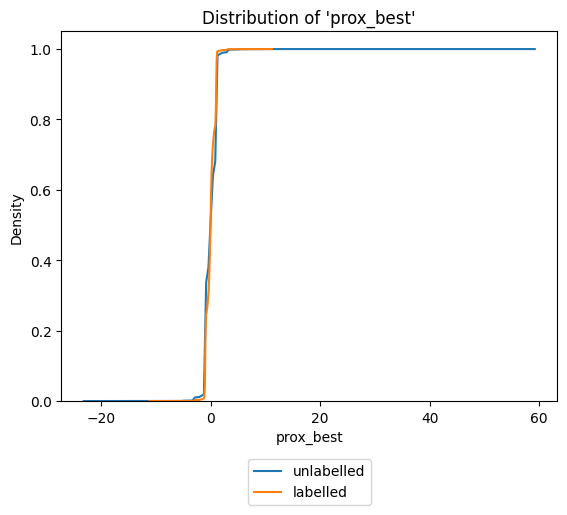

 68%|██████▊   | 15/22 [03:02<01:05,  9.36s/it]

Median value of unlabelled =  0.0000
Median value of labelled =  0.0000


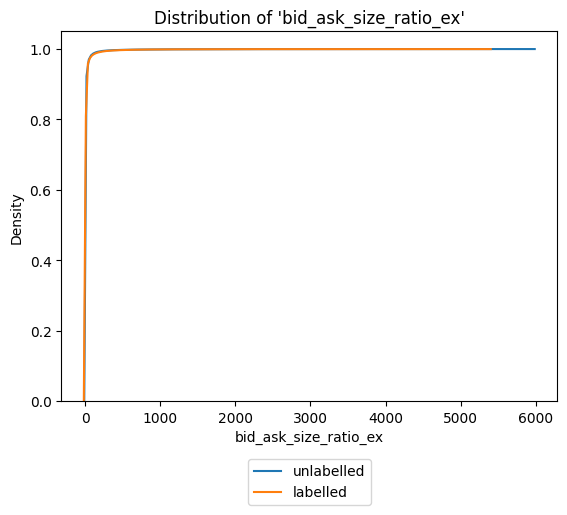

 73%|███████▎  | 16/22 [03:17<01:05, 10.92s/it]

Median value of unlabelled =  1.0000
Median value of labelled =  0.9524


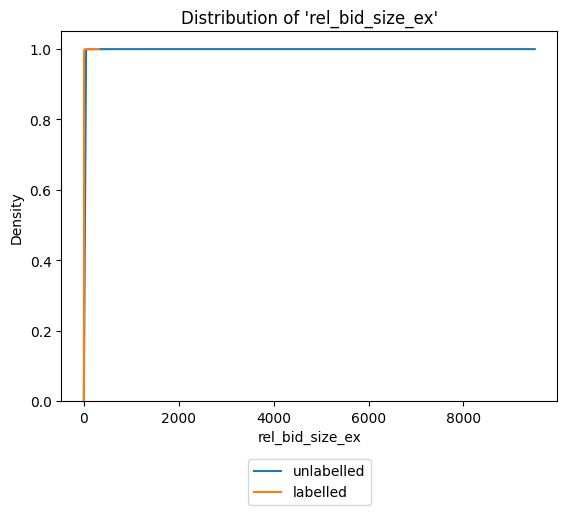

 77%|███████▋  | 17/22 [03:31<01:00, 12.00s/it]

Median value of unlabelled =  0.1367
Median value of labelled =  0.0732


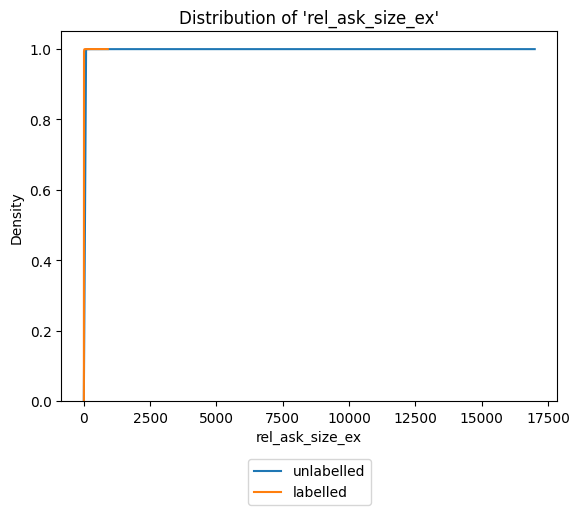

 82%|████████▏ | 18/22 [03:46<00:51, 12.82s/it]

Median value of unlabelled =  0.1364
Median value of labelled =  0.0714


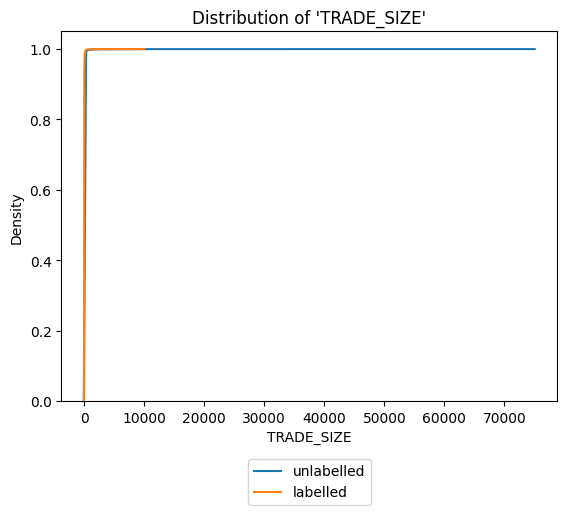

 86%|████████▋ | 19/22 [04:01<00:40, 13.50s/it]

Median value of unlabelled =  5.0000
Median value of labelled =  3.0000


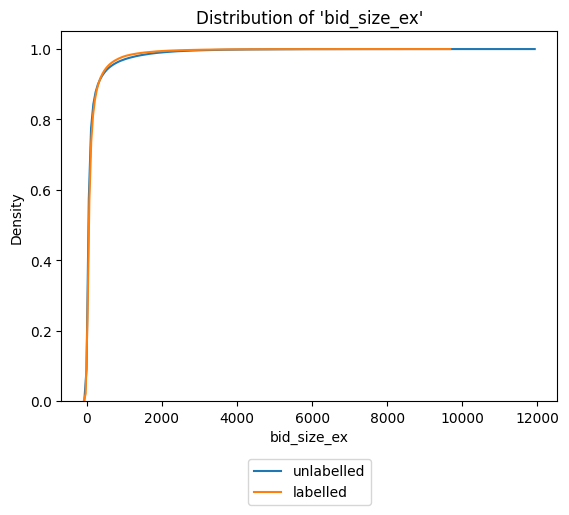

 91%|█████████ | 20/22 [04:16<00:27, 13.91s/it]

Median value of unlabelled =  35.0000
Median value of labelled =  48.0000


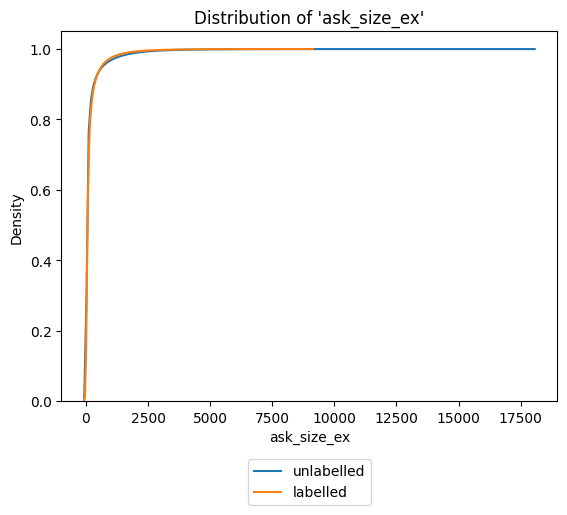

 95%|█████████▌| 21/22 [04:31<00:14, 14.16s/it]

Median value of unlabelled =  36.0000
Median value of labelled =  53.0000


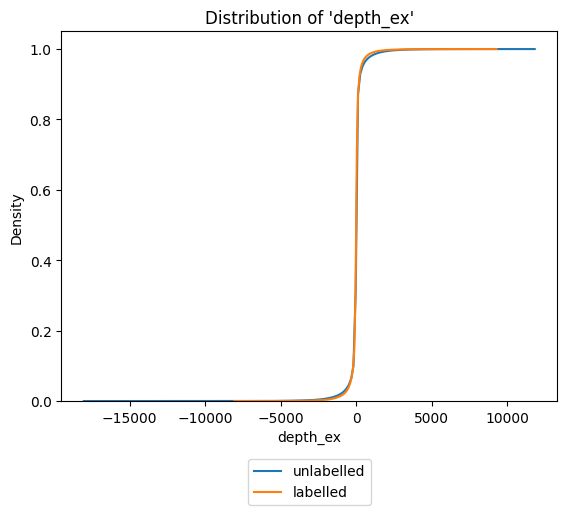

100%|██████████| 22/22 [04:39<00:00, 12.73s/it]

Median value of unlabelled =  0.0000
Median value of labelled = -2.0000


In [13]:
keys = data.columns.tolist()
keys.remove("buy_sell")
keys.remove("src")

for key in tqdm(keys):
    plot_kde_src(key)

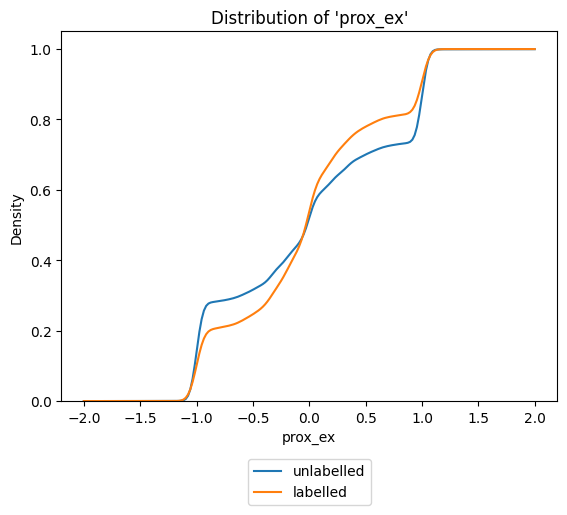

Median value of unlabelled =  0.0000
Median value of labelled =  0.0000


In [17]:
plot_kde_src("prox_ex", [-2, 2])

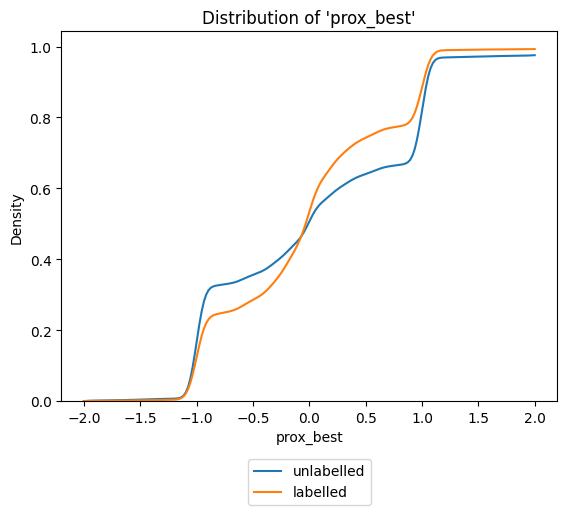

Median value of unlabelled =  0.0000
Median value of labelled =  0.0000


In [15]:
plot_kde_src("prox_best", [-2,2])

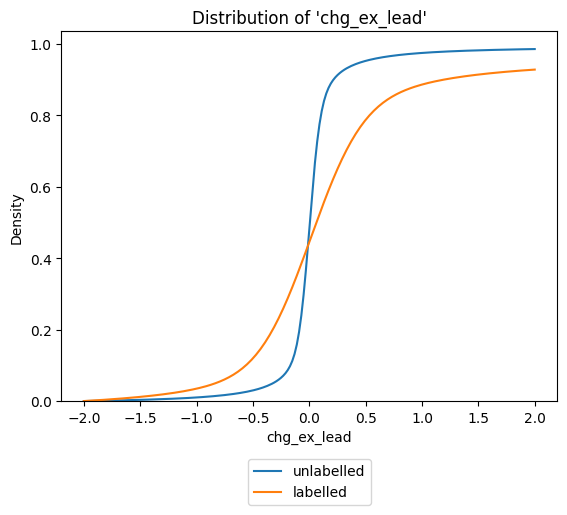

Median value of unlabelled =  0.0100
Median value of labelled =  0.0100


In [18]:
plot_kde_src("chg_ex_lead", [-2,2])

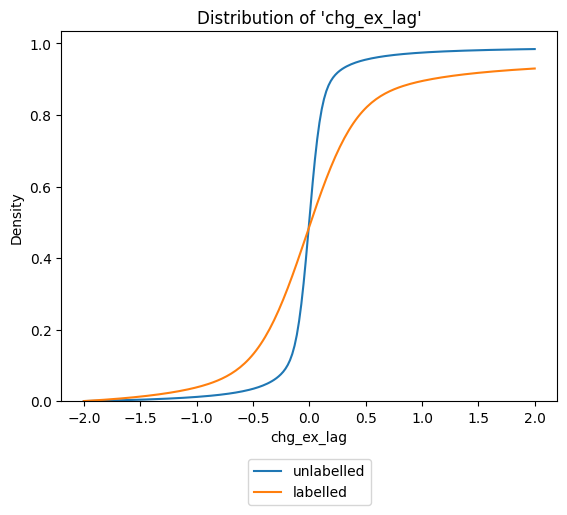

Median value of unlabelled = -0.0100
Median value of labelled = -0.0100


In [19]:
plot_kde_src("chg_ex_lag", [-2,2])